<a href="https://colab.research.google.com/github/pelegharel/robotics-final/blob/master/wall_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf robotics-final
!git clone https://github.com/pelegharel/robotics-final.git

Cloning into 'robotics-final'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 8), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [0]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from ipywidgets import interact
from ipywidgets import widgets
from IPython.display import display
from itertools import islice, cycle
import cv2

# Wall tracking

In [0]:
def unit_vector(vector):
  """
  Returns a normalized vector of length 1
  """
  return vector / norm(vector)

def unit_vectors(vectors):
    """ Returns the unit vector of the vector."""
    return vectors / norm(vectors, axis=1).reshape(-1, 1)

def angle_between_many(vector, vector_collection):
    """
    Calculates the angles between one 2D vector vec (An array of size 2)
    to a collection of vectors (an array of size n X 2)
    """
    v1 = unit_vector(vector).reshape(2, 1)
    v2s = unit_vectors(vector_collection)
    
    cosines = v2s @ v1
    sinuses = np.column_stack((-v2s[:,1], v2s[:,0])) @ v1
    
    return np.arctan2(sinuses, cosines)
  
def find_rightside_points(robot_pos, robot_rotation, points_to_filter):
  """
  Given a robot position (row, col) and rotation vectors, 
  returns only the points there are to the right of the robot
  from the point of view of the robot.
  """
  vectors = points_to_filter - robot_pos
  angles = angle_between_many(robot_rotation, vectors)
  return points_to_filter[np.where(angles > 0)[0]]
  
def closest_point(robot_pos, points):
  """
  Given a robot position and a collection of points,
  returns the colsest point
  """
  norms = norm(robot_pos - points, axis=1)
  return points[np.argmin(norms)]

In [0]:
NEIGHBORS_8_CW = [(0, 1),
                  (1, 1),
                  (1, 0),
                  (1, -1),
                  (0, -1),
                  (-1, -1),
                  (-1, 0),
                  (-1, 1)]

NEIGHBORS_8_CCW = NEIGHBORS_8_CW[::-1]

def neighbor_by_angle(theta):
  """
  Given an angle, calculate the matching 8 neighbor of point (0,0).
  Assuming row, column coordinates and
  that the angle is relative to vector (0, 1)
  """
  if theta < 0:
    theta = 2 * np.pi  + theta
  return NEIGHBORS_8_CW[int(theta // (np.pi / 4)) % 8]

def neighbor_by_direction(direction):
  return neighbor_by_angle(np.arctan2(direction[0], direction[1]))

def cw_neighbors_from(neighbor):
  """
  Given a nieghbor, returns the 8 neighbors starting from that position
  advencing at a clockwise manner.
  """
  start = NEIGHBORS_8_CW.index(neighbor)
  it = cycle(NEIGHBORS_8_CW)
  return list(islice(it, start, start + 8))

def ccw_neighbors_from(neighbor):
  """
  Given a nieghbor, returns the 8 neighbors starting from that position
  advencing at a counter clockwise manner.
  """
  start = NEIGHBORS_8_CCW.index(neighbor)
  it = cycle(NEIGHBORS_8_CCW)
  return list(islice(it, start, start + 8))

def neighbors_from(pos, neighbors):
  return [np.add(pos, n) for n in neighbors]

def track_start_point(wmap, robot_position, wall_point):
  vec = np.subtract(wall_point, robot_position)
  neighbor = neighbor_by_direction(vec)
  
  
  return next(((r, c)
               for r, c in neighbors_from(wall_point,
                                          ccw_neighbors_from(neighbor))
               if wmap[r, c] == VACANT),
              None)

def next_wall_trace_pos(wmap, pos, direction):
  neighbor = neighbor_by_direction(direction)
  cw_neighbors = cw_neighbors_from(neighbor)
  
  world_neighbors = [np.add(pos, n) for n in cw_neighbors]
 
  return next(
      (
          (rot, (cr, cc))
          for rot, (cr, cc), (nr, nv) in zip(cw_neighbors,
                                             world_neighbors,
                                             world_neighbors[1:])
          if all([(wmap[cr, cc] == VACANT),
                  (wmap[nr, nv] == OCCUPIED),
                  ((cr, cc) != pos)])
      ),
      None)

def track_wall(wmap,
               robot_position,
               robot_rotation,
               wall_point):
  pos = track_start_point(wmap, robot_position, wall_point)
  rot = robot_rotation
  while True:
    yield pos
    next_trace = next_wall_trace_pos(wmap, pos, rot)
    if next_trace is None:
      return
    rot, pos = next_trace 

In [0]:
def plot_state(world_map,
               points_of_right,
               min_right_point,
               robot_pos,
               robot_rotation,
               track_start,
               track_points):
  """
  Plots the map of the world and deduced properties
  """
  plt.imshow(world_map)
  plt.scatter(points_of_right[:,1],
              points_of_right[:,0],
              color='green')
  
  plt.scatter(*min_right_point[::-1], color='blue')  
  plt.scatter(*robot_pos[::-1], color='red')
  plt.arrow(robot_pos[1], robot_pos[0],
            3 * robot_rotation[1],
            3 * robot_rotation[0],
            color='red')
  
  track_arr = np.array(track_points)
  plt.scatter(track_arr[:, 1], track_arr[:, 0], color="yellow")
  plt.scatter(*track_start[::-1], color="pink")

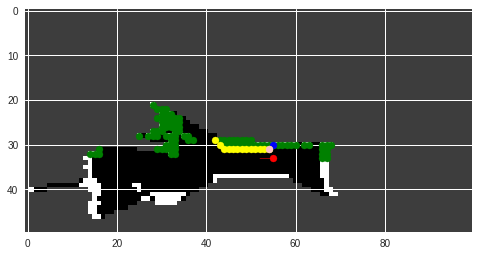

In [6]:
VACANT = 254
UKNOWN = 205
OCCUPIED = 0

wm = cv2.imread("robotics-final/map.pgm")[150:200, 150:250, 1]
robot_pos = (33, 55)

robot_rotation = (0, -1)

rightside_points = find_rightside_points(robot_pos,
                                         robot_rotation,
                                         np.argwhere(wm == OCCUPIED))

min_right_point = closest_point(robot_pos, rightside_points)


track_points = list(track_wall(wm, robot_pos, robot_rotation, min_right_point))

plot_state(wm,
           points_of_right=rightside_points,
           min_right_point=min_right_point,
           robot_pos=robot_pos,
           robot_rotation=robot_rotation,
           track_start=track_start_point(wm, robot_pos, min_right_point),
           track_points=track_points)
  

# Box recognition

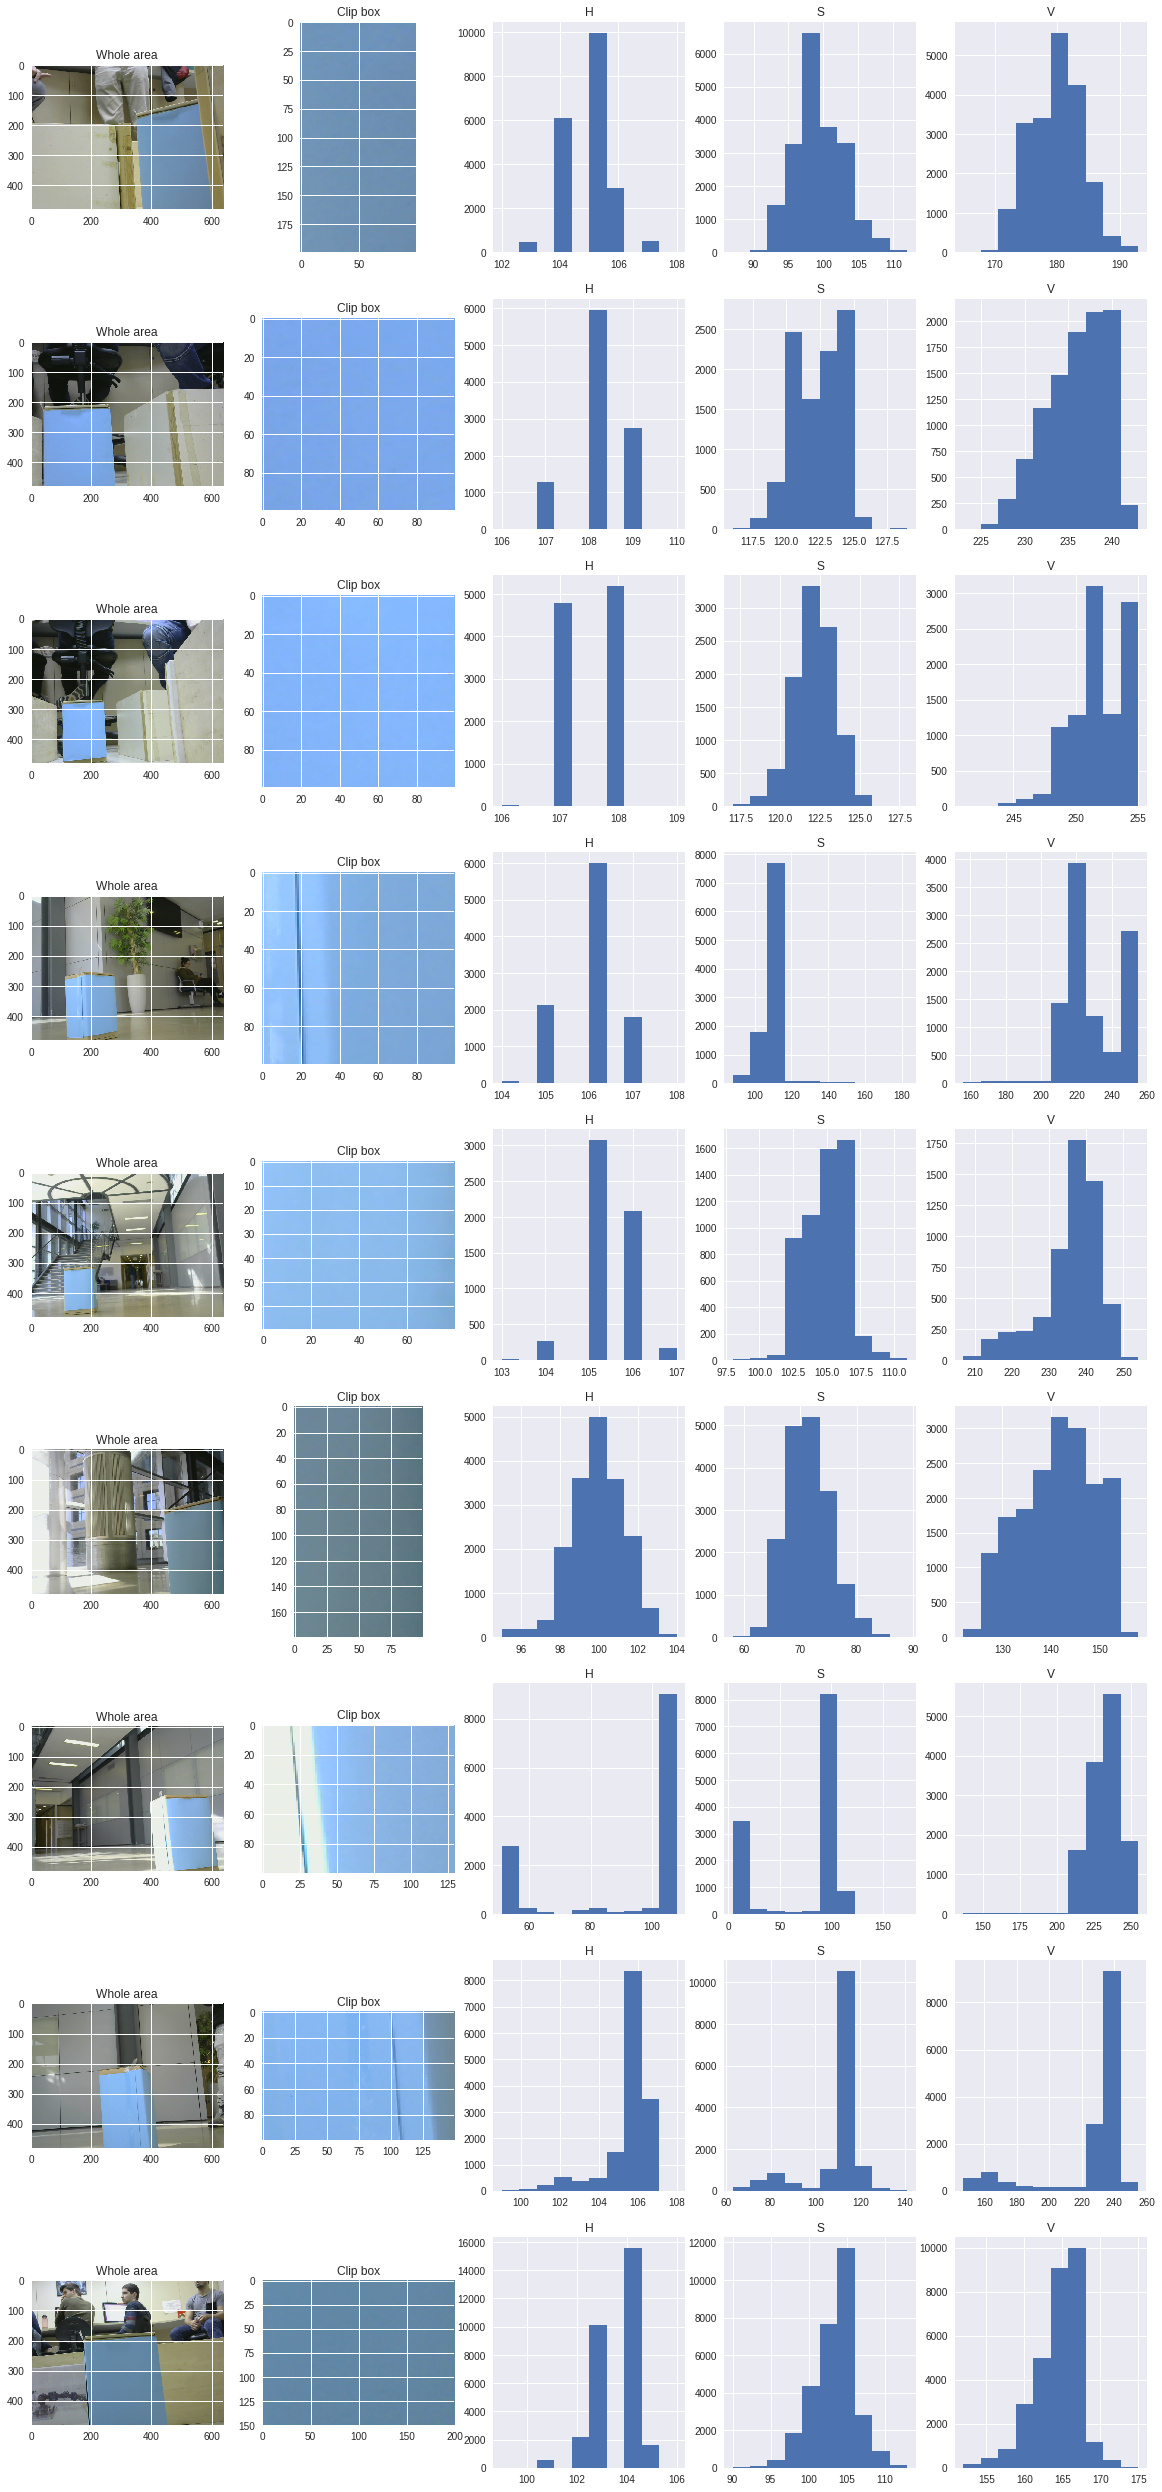

In [7]:
from glob import glob

box_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
              for f in glob("robotics-final/sample_imgs/*.png")]

box_rects = [
    ((200, 400), (400, 500)),
    ((300, 400), (100, 200)),
    ((300, 400), (120, 220)),
    ((300, 400), (150, 250)),
    ((350, 420), (120, 200)),
    ((220, 400), (500, 600)),
    ((300, 400), (420, 550)),
    ((300, 400), (250, 400)),
    ((250, 400), (200, 400)),
    
    
]

blue_areas = [img[r1:r2, c1:c2]
              for img, ((r1, r2), (c1, c2)) in zip(box_images,box_rects)]

hsv_images = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in blue_areas]

_, axes = plt.subplots(len(box_rects), 5, figsize=(20, 5 * len(box_rects)))

for (oriringl_img,
      img,
      hsv_image,
      original_img_ax,
      img_ax,
      h_ax,
      s_ax,
      v_ax) in zip(box_images,
                   blue_areas,
                   hsv_images,
                   *[axes[:, i] for i in range(5)]):
  original_img_ax.imshow(oriringl_img)
  original_img_ax.set_title("Whole area")
  
  img_ax.imshow(img)
  img_ax.set_title("Clip box")
  
  for (i, ax), title in zip(enumerate([h_ax, s_ax, v_ax]),
                            ["H", "S", "V"]):
    ax.hist(hsv_image[:, :, i].flatten())
   # ax.set_xlim(0, 255)
    ax.set_title(title)
plt.savefig("hists.png")